In [1]:
import datetime
import os
import random

import joblib
import numpy as np
import tensorflow as tf
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
from tensorflow import keras

from Dataset import Dataset
from FeatureEngineeringService import FeatureEngineeringService
from FeatureEngineeringStrategy import *

HOME = os.environ['LIMA_HOME']
# set random seed
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value) 
h = 1
past = 10
training_ratio=0.7

In [2]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
def evaluate_series(y_true, y_pred, horizon):
    """
    Some models (like ARIMA) may not support cross_validate(), compare the forecasting result directly
    Args:
        y_true: y of test set
        y_pred: y of prediction
        horizon: forecast horizon

    Returns:
        DataFrame: single row DF with 3 metrics wrt horizon
    """
    # RMSE
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2=r2_score(y_true, y_pred)
    forecast_error = {
        'h': horizon,
        'mae': [mae],
        'rmse': [rmse],
        'mape': [mape],
        'r2':[r2],
        'descriptions': ""
    }
    return forecast_error

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

        names += [f'{data.columns[j]}(t-{i})' for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{data.columns[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{data.columns[j]}(t+{i})' for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Feature Extraction

In [4]:
news_feature_helper = FeatureProviderFactory.get_provider("news")
price_feature_helper = FeatureProviderFactory.get_provider(
            "price") 
df_news_feature = news_feature_helper.get_feature(
        mode="build")
df_price_feature, df_dt = price_feature_helper.get_feature(
        mode="build")

In [5]:
df_Xy = pd.concat([df_news_feature, df_price_feature],axis=1,                    join="inner")
# joblib.dump(df_Xy,"tmp/df_Xy.joblib")
# df_Xy=joblib.load("tmp/df_Xy.joblib")

In [6]:
df_Xy=df_Xy[df_Xy.index>="2011-04-01"]
df_Xy=df_Xy[df_Xy.index<="2019-04-01"]

In [7]:
df_Xy.head(3)

,Polarity,Subjectivity,Combined_Sentiment,Decay_Polarity,Decay_Subjectivity,Decay_Combined_Sentiment,Topic1,Topic2,Topic3,Topic4,...,Decay_Geopolitical_Threats,Decay_Nuclear_Threats,Decay_War_Threats,Decay_Terrorist_Threats,Decay_War_Acts,Decay_Terrorist_Acts,CLC4,CLC3,CLC2,CLC1
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-01,0.085833,0.347500,0.115660,0.060119,0.446071,0.084436,0.133230,0.266711,0.196648,0.389213,...,0.923041,0.764067,0.673147,0.667264,1.035576,1.062797,109.17,108.94,108.50,107.94
2011-04-04,0.068889,0.342222,0.092464,0.176389,0.959008,0.246140,0.143312,0.197903,0.314226,0.305502,...,0.781256,0.665039,0.583094,0.594434,0.938713,0.969097,109.83,109.53,109.05,108.47
2011-04-05,0.024181,0.299536,0.031424,0.155625,1.015314,0.214869,0.177093,0.206282,0.197064,0.390251,...,0.782248,0.729914,0.577842,0.582328,0.920887,0.995813,109.91,109.56,108.99,108.34


In [8]:
df_Xy.tail(3)

,Polarity,Subjectivity,Combined_Sentiment,Decay_Polarity,Decay_Subjectivity,Decay_Combined_Sentiment,Topic1,Topic2,Topic3,Topic4,...,Decay_Geopolitical_Threats,Decay_Nuclear_Threats,Decay_War_Threats,Decay_Terrorist_Threats,Decay_War_Acts,Decay_Terrorist_Acts,CLC4,CLC3,CLC2,CLC1
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-28,-0.019507,0.339305,-0.026125,-0.133724,0.908372,-0.182488,0.129218,0.175803,0.219396,0.109485,...,0.797849,0.773509,0.586512,0.664073,0.966407,1.005316,59.76,59.63,59.48,59.30
2019-03-29,0.208462,0.309487,0.272978,0.100826,0.965868,0.128440,0.114900,0.199383,0.299585,0.078013,...,0.825752,0.785170,0.592541,0.715096,0.963197,1.042693,60.49,60.40,60.28,60.14
2019-04-01,-0.071296,0.215741,-0.086678,-0.226358,1.236487,-0.584150,0.094111,0.115631,0.175034,0.093650,...,0.924013,0.883445,0.636587,0.727725,1.065803,1.191592,61.83,61.80,61.71,61.59


In [9]:
df_shifted = series_to_supervised(df_Xy.dropna(), past, h)
# remove current day features for forecast
for each in df_shifted.columns[:-1]:
    if "(t)" in each:
        df_shifted.drop(each, axis=1, inplace=True)

In [10]:
df_shifted.head(3)

,Polarity(t-10),Subjectivity(t-10),Combined_Sentiment(t-10),Decay_Polarity(t-10),Decay_Subjectivity(t-10),Decay_Combined_Sentiment(t-10),Topic1(t-10),Topic2(t-10),Topic3(t-10),Topic4(t-10),...,Decay_Nuclear_Threats(t-1),Decay_War_Threats(t-1),Decay_Terrorist_Threats(t-1),Decay_War_Acts(t-1),Decay_Terrorist_Acts(t-1),CLC4(t-1),CLC3(t-1),CLC2(t-1),CLC1(t-1),CLC1(t)
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-15,0.085833,0.347500,0.115660,0.060119,0.446071,0.084436,0.133230,0.266711,0.196648,0.389213,...,0.766220,0.718494,0.608394,0.926449,0.938652,109.49,109.19,108.70,108.11,109.66
2011-04-18,0.068889,0.342222,0.092464,0.176389,0.959008,0.246140,0.143312,0.197903,0.314226,0.305502,...,0.746939,0.705949,0.588953,0.937933,0.900554,110.96,110.68,110.22,109.66,107.12
2011-04-19,0.024181,0.299536,0.031424,0.155625,1.015314,0.214869,0.177093,0.206282,0.197064,0.390251,...,0.678688,0.567106,0.593173,0.847213,0.898380,108.42,108.15,107.69,107.12,108.15


In [11]:
# add time feature without shift
df_shifted = pd.concat([df_dt, df_shifted], axis=1).dropna()
raw_X = df_shifted.to_numpy()[:, :-1]
y = df_shifted.to_numpy()[:, -1].reshape(-1, 1)

In [12]:
df_shifted.tail(3)

,month,day,day_in_week,Polarity(t-10),Subjectivity(t-10),Combined_Sentiment(t-10),Decay_Polarity(t-10),Decay_Subjectivity(t-10),Decay_Combined_Sentiment(t-10),Topic1(t-10),...,Decay_Nuclear_Threats(t-1),Decay_War_Threats(t-1),Decay_Terrorist_Threats(t-1),Decay_War_Acts(t-1),Decay_Terrorist_Acts(t-1),CLC4(t-1),CLC3(t-1),CLC2(t-1),CLC1(t-1),CLC1(t)
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-28,3,28,3,-0.031101,0.151511,-0.035813,-0.183627,0.581536,-0.225676,0.079573,...,0.757268,0.566983,0.661205,0.947744,0.972369,59.91,59.77,59.61,59.41,59.30
2019-03-29,3,29,4,0.011859,0.161859,0.013778,-0.096372,0.524129,-0.115866,0.156320,...,0.773509,0.586512,0.664073,0.966407,1.005316,59.76,59.63,59.48,59.30,60.14
2019-04-01,4,1,0,0.039366,0.253747,0.049355,-0.003102,0.454577,0.001292,0.103892,...,0.785170,0.592541,0.715096,0.963197,1.042693,60.49,60.40,60.28,60.14,61.59


# Feature Selection

In [13]:
from sklearn.feature_selection import mutual_info_regression,RFE,RFECV,SelectFromModel,SequentialFeatureSelector,chi2,SelectKBest,f_regression,VarianceThreshold,r_regression
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.linear_model import LinearRegression,Ridge
def get_TS_cv(k=5, test_size=None):
    """
    ML models do not need to care about forecast horizon when splitting training and test set. Forecast horizon should be handled by feature preparation ([X_t-1,X_t-2...]). Actually repeated K-fold can also be used, but stick to TS split to align with TS_evaluate().
    """
    return TimeSeriesSplit(
        n_splits=k,
        gap=0,
        test_size=test_size,
    )

In [14]:
estimator = LinearRegression()
feature_selector = SequentialFeatureSelector(estimator,n_features_to_select=20,cv=get_TS_cv(),n_jobs=-1)
feature_selector = feature_selector.fit(raw_X, y.ravel())
X = raw_X[:, feature_selector.get_support()]

In [15]:
df_shifted.columns[:-1][feature_selector.get_support()]

Index(['Decay_Topic3(t-10)', 'Decay_Topic4(t-10)', 'CLC1(t-10)',
       'Subjectivity(t-9)', 'Topic2(t-9)', 'Decay_Topic1(t-9)', 'CLC3(t-8)',
       'Decay_Combined_Sentiment(t-6)', 'Geopolitical_Threats(t-6)',
       'Topic4(t-5)', 'Polarity(t-3)', 'War_Acts(t-3)', 'Topic5(t-2)',
       'Decay_Topic4(t-2)', 'Terrorist_Threats(t-2)', 'CLC1(t-2)',
       'Terrorist_Threats(t-1)', 'Terrorist_Acts(t-1)',
       'Decay_War_Threats(t-1)', 'CLC1(t-1)'],
      dtype='object')

# Dataset

In [16]:
training_ratio=0.7

In [17]:
dataset = Dataset(X=X, y=y, idx=df_shifted.index,train_ratio=training_ratio)

# Linear Model

In [18]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge

linear_model=LinearRegression()
linear_model.fit(dataset.train_X, dataset.train_y)
pred_linear_y = linear_model.predict(dataset.feature)

In [19]:
df_linear=pd.DataFrame(pred_linear_y ,index=dataset.idx)
df_linear.tail(3)

,0
Date,
2019-03-28,59.613654
2019-03-29,59.476711
2019-04-01,60.237310


# Nonlinear data processing

In [20]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
def stationary_test(data):
    for i in range(data.shape[1]):
        test_result = adfuller(data[:, i])
        if test_result[1] > 0.05:
            return False
    return True

def stl_decompose(data):
    stl = STL(data, 10)
    res = stl.fit()
    non_linear_trend = res.trend.reshape(-1, 1)
    non_linear_season = res.seasonal.reshape(-1, 1)
    non_linear_residual = res.resid.reshape(-1, 1)
    non_linear_y = np.concatenate(
        [non_linear_season, non_linear_trend, non_linear_residual], axis=1)
    return non_linear_y

def differencing(data):
    diffed_data = np.diff(data, axis=0)
    return diffed_data

def ensure_stationary(data):
    diff_order = 0
    feature = data.feature
    label = data.label
    while not stationary_test(feature):
        feature = differencing(feature)
        diff_order += 1
    label = label[diff_order:]
    return feature, label, diff_order

In [21]:
non_linear_y = dataset.label - pred_linear_y.reshape(
    dataset.label.shape)
non_linear_y.shape

(2003, 1)

In [22]:
nonlinear_data = Dataset(X=X,
                            y=non_linear_y,
                            idx=df_shifted.index,
                            scaling=True,train_ratio=training_ratio)

In [23]:
nonlinear_data.label = stl_decompose(nonlinear_data.label)
nonlinear_data.update()

# NonLinear Model

In [24]:
import tensorflow as tf
from keras.layers import (GRU, LSTM, Bidirectional, Conv1D, Conv2D, Conv3D,
                          ConvLSTM2D, Dense, Dropout, Flatten, Input,
                          MaxPooling2D, Reshape, SimpleRNN)
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from matplotlib import pyplot
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [25]:
num_feature=nonlinear_data.feature.shape[-1]
num_label=nonlinear_data.label.shape[-1]

In [26]:
tf.keras.backend.clear_session()
# set random seed 
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

input_layer = Input(shape=(num_feature,))
bimodel_draft = Reshape((num_feature, 1))(input_layer)
bimodel_draft =  Bidirectional( GRU(50, dropout=0.2, return_sequences=True)) (bimodel_draft)
bimodel_draft = Dropout(0.4)(bimodel_draft)
bimodel_draft =  Bidirectional( GRU(50, dropout=0.2, return_sequences=True)) (bimodel_draft)
bimodel_draft = Dropout(0.4)(bimodel_draft)
bimodel_draft =  Bidirectional( GRU(50, dropout=0.2, return_sequences=True)) (bimodel_draft)
bimodel_draft = Dropout(0.4)(bimodel_draft)
bimodel_draft =  Bidirectional( GRU(50, dropout=0.2, return_sequences=True)) (bimodel_draft)
bimodel_draft = Dropout(0.4)(bimodel_draft)
bimodel_draft =  Bidirectional( GRU(50, dropout=0.2, return_sequences=False)) (bimodel_draft)
bimodel_draft = Dropout(0.4)(bimodel_draft)
bimodel_draft = Flatten()(bimodel_draft)
bimodel_draft = Dense(num_label)(bimodel_draft)
bimodel= Model(inputs=input_layer, outputs=bimodel_draft)
bimodel.compile(loss='log_cosh', optimizer=Adam(0.0002))
bimodel.summary()

2022-04-07 14:02:26.449630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 14:02:26.474707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 14:02:26.474875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 14:02:26.475600: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 reshape (Reshape)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 100)          15900     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 100)          45600     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 20, 100)           0     

Epoch 1/200


2022-04-07 14:02:35.856147: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2022-04-07 14:02:36.483858: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


36/36 [==============================] - 11s 54ms/step - loss: 47.8109 - val_loss: 45.4049
Epoch 2/200
36/36 [==============================] - 0s 9ms/step - loss: 43.5357 - val_loss: 41.1189
Epoch 3/200
36/36 [==============================] - 0s 10ms/step - loss: 40.8305 - val_loss: 39.5506
Epoch 4/200
36/36 [==============================] - 0s 10ms/step - loss: 39.4415 - val_loss: 38.5147
Epoch 5/200
36/36 [==============================] - 0s 9ms/step - loss: 38.4491 - val_loss: 37.5974
Epoch 6/200
36/36 [==============================] - 0s 9ms/step - loss: 37.5193 - val_loss: 36.7317
Epoch 7/200
36/36 [==============================] - 0s 9ms/step - loss: 36.6712 - val_loss: 35.8996
Epoch 8/200
36/36 [==============================] - 0s 9ms/step - loss: 35.9021 - val_loss: 35.0933
Epoch 9/200
36/36 [==============================] - 0s 10ms/step - loss: 35.1010 - val_loss: 34.2998
Epoch 10/200
36/36 [==============================] - 0s 10ms/step - loss: 34.3004 - val_loss: 33.

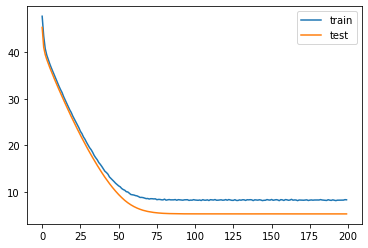

In [27]:
history = bimodel.fit(nonlinear_data.train_X,
                            nonlinear_data.train_y,
                            validation_data=(nonlinear_data.test_X,
                            nonlinear_data.test_y),
                            epochs=200,
                            batch_size=40,
                            verbose=1,
                            shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Evaluate


In [28]:
df_forecast_error = pd.DataFrame(
        columns=['seed', 'mae', 'rmse', 'mape', 'descriptions'])
pred_nonliner_test_y=bimodel.predict(nonlinear_data.test_X)
inverted_pred_nonlinear_test_y=nonlinear_data.label_scaler.inverse_transform(pred_nonliner_test_y)
pred_combined_nonlinear_test_y = pd.DataFrame(inverted_pred_nonlinear_test_y).apply(lambda x: x.sum(), axis=1).to_numpy().reshape(-1, 1)
df_pred_linear_y=df_linear[df_linear.index.isin(nonlinear_data.test_idx)]
pred_linear_test_y = df_pred_linear_y.to_numpy()

pred_final = pred_combined_nonlinear_test_y.ravel()   + pred_linear_test_y.ravel() 
test_real_y=y[-pred_final.shape[0]:]
result=evaluate_series(test_real_y,pred_final,1)
result['descriptions']="BiGRU"
result['seed']=seed_value
df_forecast_error=df_forecast_error.append(result,ignore_index=True)

In [29]:
df_forecast_error

,seed,mae,rmse,mape,descriptions,h,r2
0,42,[0.7408232246530382],[0.9969050881869899],[0.01318231451009793],BiGRU,1.0,[0.986208201430629]


# Performance

In [31]:
new_label_scaler=MinMaxScaler()# [0,1]
new_label_scaler.fit(dataset.train_y)
scaled_test_y=new_label_scaler.transform(dataset.test_y)
scaled_pred_y=new_label_scaler.transform(pred_final.reshape(-1,1))

In [32]:
evaluate_series(test_real_y,pred_final,1)

{'h': 1,
 'mae': [0.7408232246530382],
 'rmse': [0.9969050881869899],
 'mape': [0.01318231451009793],
 'r2': [0.986208201430629],
 'descriptions': ''}

In [33]:
evaluate_series(scaled_test_y,scaled_pred_y,1)

{'h': 1,
 'mae': [0.00844531719850705],
 'rmse': [0.011364627088314976],
 'mape': [0.025645882682705165],
 'r2': [0.986208201430629],
 'descriptions': ''}